In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
path_wt = data_path + 'Imaging/PAR-2 NEBD/210722_lp637_tom4,15,60/00'
path_gcn4 = data_path + 'Imaging/PAR-2 NEBD/210722_nwg376_tom4,15,60/00'
path_c56s = data_path + 'Imaging/PAR-2 NEBD/210428_nwg240_tom4,15,60/05'
path_c56s_gcn4 = '/Users/blandt/Desktop/Data/PAR2 GCN4/c56s_gcn4/210816_nwg381_tom4,15,60/02'
path_l109r = data_path + 'Imaging/PAR-2 NEBD/211106_nwg338_tom4,15,60/00'
path_l109r_gcn4 = data_path + 'Imaging/PAR-2 NEBD/220823_nwg398_tom4,15,60/35'

### Images with boxes

<IPython.core.display.Javascript object>


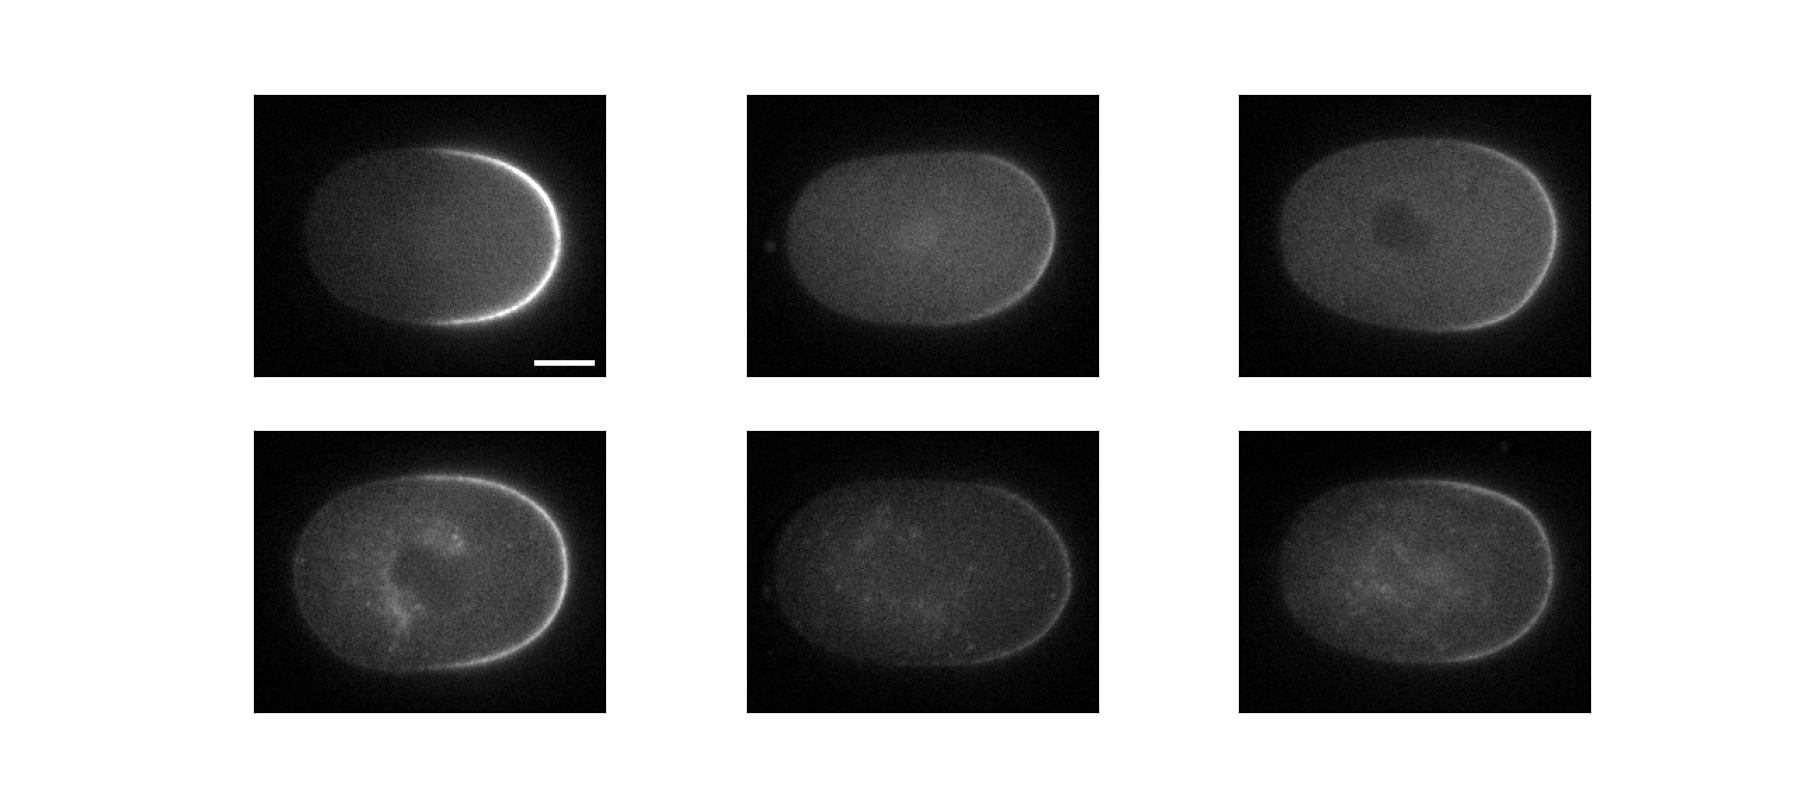

In [3]:
import matplotlib.patches as patches

def func_af(path, ax, scale_bar=False):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI.txt')
    rotated = rotated_embryo(img, roi, 250, 200, 3)
    ax.imshow(rotated, cmap='gray', vmin=0, vmax=25000)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     # Endosome box
#     recta = patches.Rectangle((ybox_a[0], xbox_a[0]), ybox_a[1] - ybox_a[0], xbox_a[1] - xbox_a[0], 
#                          linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
#     ax.add_patch(recta)
    
#     # Anterior membrane box
#     rectb = patches.Rectangle((ybox_b[0], xbox_b[0]), ybox_b[1] - ybox_b[0], xbox_b[1] - xbox_b[0], 
#                          linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
#     ax.add_patch(rectb)
    
    if scale_bar:
        px = 0.255 # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot([rotated.shape[1]-10-bar_pixels, rotated.shape[1]-10], [y, y], color='w', linewidth=2)


fig, ax = plt.subplots(2, 3)
func_af(path_wt, ax[0][0], scale_bar=True)
func_af(path_gcn4, ax[1][0])
func_af(path_c56s, ax[0][1])
func_af(path_c56s_gcn4, ax[1][1])
func_af(path_l109r, ax[0][2])
func_af(path_l109r_gcn4, ax[1][2])

# ax[0].set_ylabel('PAR-2 (WT)', fontsize=10)
# ax[1].set_ylabel('PAR-2 (+GCN4)', fontsize=10)
fig.set_size_inches(9, 4)

### Membrane quantification: wt vs GCN4

<IPython.core.display.Javascript object>


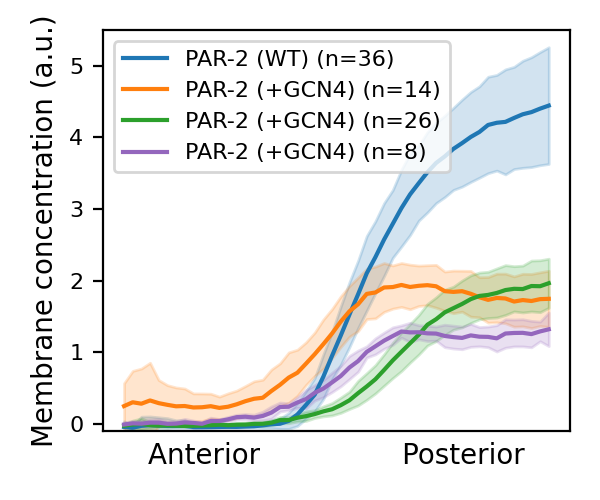

In [4]:
df = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
df = df[df.RNAi == 'wt']
df_quantification = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/QUANTIFICATION.csv')

def fold(array):
    return (array[:50][::-1] + array[50:]) / 2

def func(line, ax, c, label):
    embryoIDs = df[df.Line == line].EmbryoID.to_list()
    df_quant_filtered = df_quantification[df_quantification.EmbryoID.isin(embryoIDs)]
    mems = df_quant_filtered.groupby('EmbryoID').apply(lambda x: interp_1d_array(x['Membrane signal'].to_numpy(), 
                                                                                 100))
    mems_ = np.array([fold(x) / 10000 for x in mems])
    mems_mean = np.mean(mems_, axis=0)
    mems_std = np.std(mems_, axis=0)
    ax.plot(mems_mean, c=c, label=label + ' (n=%s)'  % len(mems))
    ax.fill_between(np.arange(50), mems_mean - mems_std, mems_mean + mems_std, color=c, alpha=0.2)

   
fig, ax = plt.subplots()
func('lp637', ax, 'tab:blue', 'PAR-2 (WT)')
func('nwg376', ax, 'tab:orange', 'PAR-2 (+GCN4)')
# func('nwg240', ax, 'tab:green', 'PAR-2 (+GCN4)')
func('nwg338', ax, 'tab:green', 'PAR-2 (+GCN4)')
func('nwg398', ax, 'tab:purple', 'PAR-2 (+GCN4)')
ax.set_ylim(bottom=0)
ax.set_xlabel('Anterior                Posterior')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.set_xticks([])
ax.set_ylim(-0.1, 5.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.legend(fontsize=8, loc='upper left')
fig.set_size_inches(3,2.5)
fig.tight_layout()

### Dosage

In [5]:
def calc_dosage(df, line):
    df_new = df[df.Line == line] 
    imgs = [load_image(p + '/af_corrected.tif') for p in df_new.Path]
    rois = [np.loadtxt(p + '/ROI_fit.txt') for p in df_new.Path]
    dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
    df_new['Dosage'] = dosages
    return df_new

dosages = pd.concat([calc_dosage(df, x) for x in ['lp637', 'nwg376', 'nwg240', 'nwg381', 'nwg338', 'nwg398']])

/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


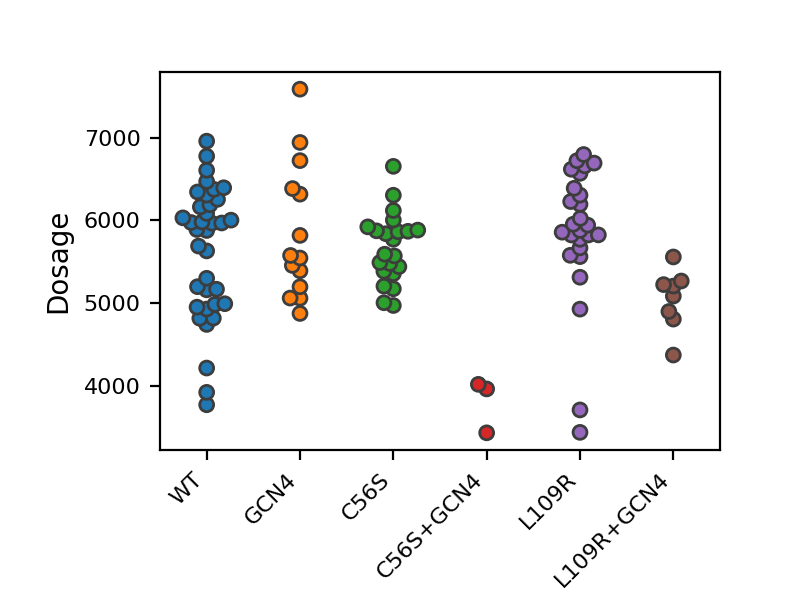

In [31]:
fig, ax = plt.subplots()
sns.swarmplot(data=dosages, x='Line', y='Dosage', ax=ax, linewidth=1)
ax.set_xticklabels(['WT', 'GCN4', 'C56S', 'C56S+GCN4', 'L109R', 'L109R+GCN4'])
ax.tick_params(axis='both', labelsize=8)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
ax.set_xlabel('')
# ax.set_ylim(bottom=0)
fig.set_size_inches(4,3)
fig.subplots_adjust(bottom=0.25, left=0.2)

In [15]:
a = dosages[dosages.Line == 'lp637'].Dosage.to_numpy()
b = dosages[dosages.Line == 'nwg376'].Dosage.to_numpy()
from scipy.stats import ttest_ind
ttest_ind(a, b)

Ttest_indResult(statistic=-0.8599713368177342, pvalue=0.3940798100324644)